In [98]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [99]:
def transform_station(df):
    
    def year(row):
        _dtime = row['dtime']
        return _dtime.year

    def month(row):
        _dtime = row['dtime']
        return _dtime.month
    
    def day(row):
        _dtime = row['dtime']
        return _dtime.day

    def hour(row):
        _dtime = row['dtime']
        return _dtime.hour

    df['dtime'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
    df['year'] = df.apply(lambda row: year(row), axis = 1)
    df['month'] = df.apply(lambda row: month(row), axis = 1)
    df['day'] = df.apply(lambda row: day(row), axis = 1)
    df['hour'] = df.apply(lambda row: hour(row), axis = 1)
    
    return df

In [100]:
def transform_model(df):
    
    def year(row):
        _dtime = row['dtime']
        return _dtime.year

    def month(row):
        _dtime = row['dtime']
        return _dtime.month
    
    def day(row):
        _dtime = row['dtime']
        return _dtime.day

    def hour(row):
        _dtime = row['dtime']
        return _dtime.hour

    df['dtime'] = pd.to_datetime(df['valid_time'], format='%Y-%m-%d %H:%M:%S')
    df['year'] = df.apply(lambda row: year(row), axis = 1)
    df['month'] = df.apply(lambda row: month(row), axis = 1)
    df['day'] = df.apply(lambda row: day(row), axis = 1)
    df['hour'] = df.apply(lambda row: hour(row), axis = 1)
    
    return df

In [101]:
# loading dataset
X_station_train_df = pd.read_csv("../../Hackathon/Train/X_station_train.csv", index_col=["Id"])

# transform whole dataset
# X_station_train_df = transform_station(X_station_train_df)
# X_station_train_df.head()

In [102]:
# loading dataset
X_2D_arome_interp_2016_df = pd.read_csv("../../Hackathon/Train/X_2D_arome_interp_2016.csv")

# transform whole dataset
# X_2D_arome_interp_2016_df = transform_model(X_2D_arome_interp_2016_df)
# X_2D_arome_interp_2016_df.head()

In [106]:
X_modele_station = X_2D_arome_interp_2016_df[X_2D_arome_interp_2016_df['number_sta']==14066001]
X_modele_station = transform_model(X_modele_station)
X_modele_station

/tmp/ipykernel_27773/395785759.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dtime'] = pd.to_datetime(df['valid_time'], format='%Y-%m-%d %H:%M:%S')
/tmp/ipykernel_27773/395785759.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df.apply(lambda row: year(row), axis = 1)
/tmp/ipykernel_27773/395785759.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

,Unnamed: 0,number_sta,time,valid_time,ws,p3031,u10,v10,t2m,d2m,r,tp,msl,dtime,year,month,day,hour
34,34,14066001,2016-06-19,2016-06-19 00:00:00,4.352842,259.853539,4.271617,0.617340,286.991283,284.405660,84.432634,NaN,102539.880923,2016-06-19 00:00:00,2016,6,19,0
359,359,14066001,2016-06-19,2016-06-19 01:00:00,4.094646,260.660699,4.025737,0.511069,286.258234,284.187917,87.290501,0.0,102533.956858,2016-06-19 01:00:00,2016,6,19,1
684,684,14066001,2016-06-19,2016-06-19 02:00:00,4.319193,255.605465,4.186250,1.016522,285.557230,283.909789,89.715778,0.0,102497.491543,2016-06-19 02:00:00,2016,6,19,2
1009,1009,14066001,2016-06-19,2016-06-19 03:00:00,4.064720,248.085490,3.772996,1.509741,284.892109,283.696409,92.396568,0.0,102538.199364,2016-06-19 03:00:00,2016,6,19,3
1334,1334,14066001,2016-06-19,2016-06-19 04:00:00,4.275293,249.025561,3.994954,1.523202,284.678072,283.647051,93.396920,0.0,102549.251236,2016-06-19 04:00:00,2016,6,19,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2744659,2744659,14066001,2016-12-04,2016-12-04 20:00:00,4.984371,121.800555,-4.238409,2.619979,275.409780,273.622741,87.862315,0.0,102099.027505,2016-12-04 20:00:00,2016,12,4,20
2744984,2744984,14066001,2016-12-04,2016-12-04 21:00:00,4.658912,129.418559,-3.599201,2.958341,275.147866,273.584093,89.280736,0.0,102138.112190,2016-12-04 21:00:00,2016,12,4,21
2745309,2745309,14066001,2016-12-04,2016-12-04 22:00:00,4.423653,130.359389,-3.367171,2.867057,274.841515,273.499582,90.649198,0.0,102174.120002,2016-12-04 22:00:00,2016,12,4,22
2745634,2745634,14066001,2016-12-04,2016-12-04 23:00:00,3.854594,133.959208,-2.774266,2.672633,274.594205,273.522810,92.421569,0.0,102194.097511,2016-12-04 23:00:00,2016,12,4,23


In [107]:
station_df = X_station_train_df[X_station_train_df['number_sta']==14066001]
station_df = transform_station(station_df)
station_df

/tmp/ipykernel_27773/3348463622.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dtime'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
/tmp/ipykernel_27773/3348463622.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df.apply(lambda row: year(row), axis = 1)
/tmp/ipykernel_27773/3348463622.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,number_sta,date,ff,t,td,hu,dd,precip,dtime,year,month,day,hour
Id,,,,,,,,,,,,,
14066001_0_0,14066001,2016-01-01 00:00:00,3.05,279.28,277.97,91.4,200.0,0.0,2016-01-01 00:00:00,2016,1,1,0
14066001_0_1,14066001,2016-01-01 01:00:00,2.57,278.76,277.45,91.4,190.0,0.0,2016-01-01 01:00:00,2016,1,1,1
14066001_0_2,14066001,2016-01-01 02:00:00,2.26,278.27,277.02,91.7,181.0,0.0,2016-01-01 02:00:00,2016,1,1,2
14066001_0_3,14066001,2016-01-01 03:00:00,2.62,277.98,276.95,93.0,159.0,0.0,2016-01-01 03:00:00,2016,1,1,3
14066001_0_4,14066001,2016-01-01 04:00:00,2.99,277.32,276.72,95.9,171.0,0.0,2016-01-01 04:00:00,2016,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14066001_729_19,14066001,2017-12-30 19:00:00,9.63,285.38,283.40,87.7,233.0,0.2,2017-12-30 19:00:00,2017,12,30,19
14066001_729_20,14066001,2017-12-30 20:00:00,9.80,285.70,283.16,84.6,230.0,0.0,2017-12-30 20:00:00,2017,12,30,20
14066001_729_21,14066001,2017-12-30 21:00:00,10.67,286.07,282.83,80.8,230.0,0.0,2017-12-30 21:00:00,2017,12,30,21


In [109]:
def precip_station(month,day):
    station_ex = station_df[station_df['year']==2016][station_df['month']==month][station_df['day']==day]
    return station_ex['precip'].values

In [112]:
def precip_modele(month,day):
    station_ex = X_modele_station[X_modele_station['year']==2016][X_modele_station['month']==month][X_modele_station['day']==day]
    return station_ex['tp'].values

/tmp/ipykernel_27773/1413897160.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  station_ex = X_modele_station[X_modele_station['year']==2016][X_modele_station['month']==month][X_modele_station['day']==day]


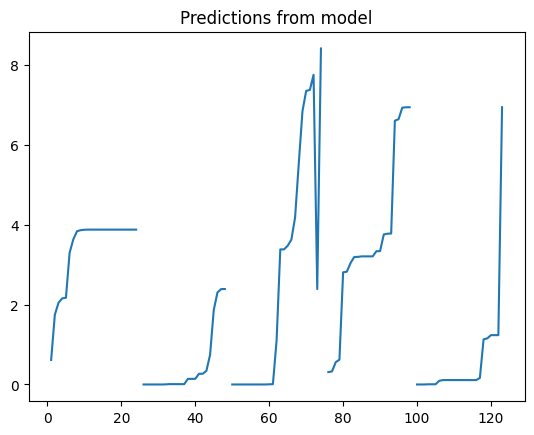

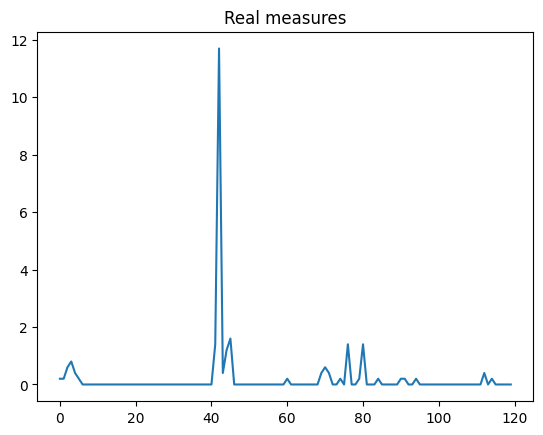

In [116]:
'''for i in range(25,30):
    p = precip_station(3,i)
    plt.plot(np.arange(24),p, label=i)
    plt.legend()'''
    
L = []
for i in range(25,30):
    p = precip_modele(3,i)
    for j in p:
        L.append(j)

plt.figure()
plt.title("Predictions from model")
plt.plot(np.arange(len(L)),L)

M = []
for i in range(25,30):
    p = precip_station(3,i)
    for j in p:
        M.append(j)

plt.figure()
plt.title("Real measures")
plt.plot(np.arange(len(M)),M)